In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
IMAGE_PATH = '/content/drive/MyDrive/DataSets/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/drive/MyDrive/DataSets/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [6]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [7]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


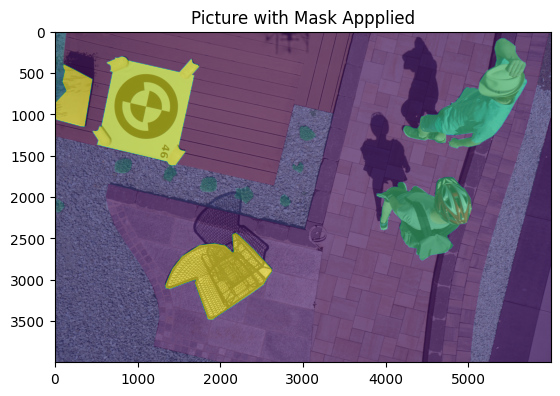

In [11]:
img = Image.open(IMAGE_PATH + df['id'][20] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][20] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [12]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [13]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [14]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 254MB/s]


In [15]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.052 
Epoch:1/15.. Train Loss: 2.910.. Val Loss: 2.052.. Train mIoU:0.036.. Val mIoU: 0.077.. Train Acc:0.159.. Val Acc:0.367.. Time: 17.41m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.052 >> 1.371 
Epoch:2/15.. Train Loss: 1.973.. Val Loss: 1.371.. Train mIoU:0.099.. Val mIoU: 0.122.. Train Acc:0.538.. Val Acc:0.623.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.371 >> 1.180 
Epoch:3/15.. Train Loss: 1.457.. Val Loss: 1.180.. Train mIoU:0.136.. Val mIoU: 0.152.. Train Acc:0.613.. Val Acc:0.653.. Time: 3.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.180 >> 1.037 
saving model...
Epoch:4/15.. Train Loss: 1.353.. Val Loss: 1.037.. Train mIoU:0.142.. Val mIoU: 0.170.. Train Acc:0.609.. Val Acc:0.702.. Time: 3.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/15.. Train Loss: 1.194.. Val Loss: 1.121.. Train mIoU:0.169.. Val mIoU: 0.183.. Train Acc:0.654.. Val Acc:0.670.. Time: 3.73m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 1.144.. Val Loss: 1.267.. Train mIoU:0.182.. Val mIoU: 0.144.. Train Acc:0.662.. Val Acc:0.583.. Time: 3.71m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.267 >> 0.873 
Epoch:7/15.. Train Loss: 1.060.. Val Loss: 0.873.. Train mIoU:0.193.. Val mIoU: 0.207.. Train Acc:0.689.. Val Acc:0.727.. Time: 3.73m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.873 >> 0.867 
Epoch:8/15.. Train Loss: 0.992.. Val Loss: 0.867.. Train mIoU:0.204.. Val mIoU: 0.213.. Train Acc:0.707.. Val Acc:0.753.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.867 >> 0.736 
Epoch:9/15.. Train Loss: 0.925.. Val Loss: 0.736.. Train mIoU:0.220.. Val mIoU: 0.233.. Train Acc:0.726.. Val Acc:0.770.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/15.. Train Loss: 0.839.. Val Loss: 0.772.. Train mIoU:0.240.. Val mIoU: 0.255.. Train Acc:0.747.. Val Acc:0.760.. Time: 3.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.772 >> 0.656 
Epoch:11/15.. Train Loss: 0.798.. Val Loss: 0.656.. Train mIoU:0.258.. Val mIoU: 0.299.. Train Acc:0.761.. Val Acc:0.810.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.656 >> 0.627 
saving model...
Epoch:12/15.. Train Loss: 0.755.. Val Loss: 0.627.. Train mIoU:0.272.. Val mIoU: 0.296.. Train Acc:0.774.. Val Acc:0.816.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.627 >> 0.596 
Epoch:13/15.. Train Loss: 0.713.. Val Loss: 0.596.. Train mIoU:0.282.. Val mIoU: 0.302.. Train Acc:0.787.. Val Acc:0.824.. Time: 3.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.596 >> 0.577 
Epoch:14/15.. Train Loss: 0.676.. Val Loss: 0.577.. Train mIoU:0.293.. Val mIoU: 0.307.. Train Acc:0.798.. Val Acc:0.829.. Time: 3.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.577 >> 0.562 
Epoch:15/15.. Train Loss: 0.675.. Val Loss: 0.562.. Train mIoU:0.295.. Val mIoU: 0.313.. Train Acc:0.798.. Val Acc:0.835.. Time: 3.73m
Total time: 69.44 m


In [20]:
torch.save(model, 'Unet-Mobilenet.pt')


In [21]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Unet-Mobilenet2.pt')


In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

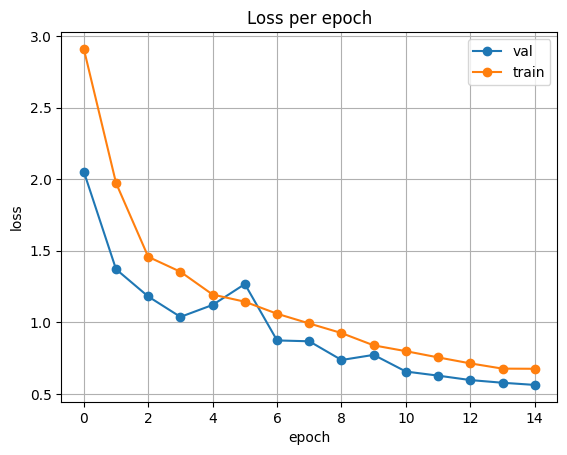

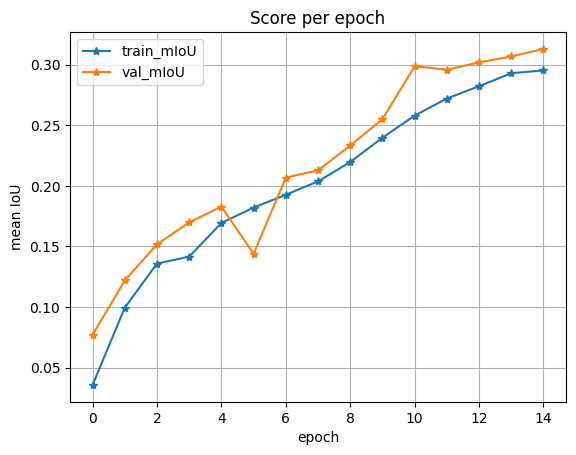

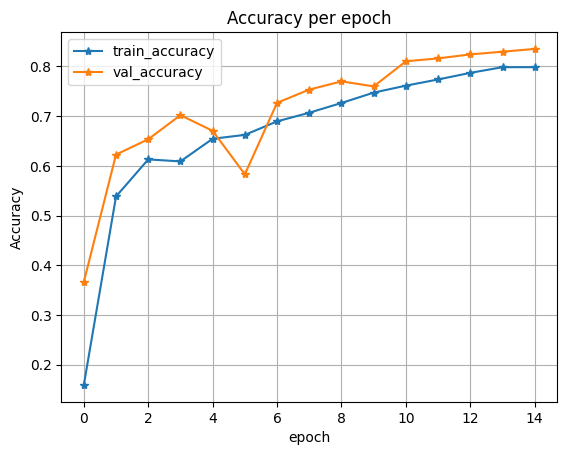

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [24]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [25]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [26]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [27]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [28]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou


In [29]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [30]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [31]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

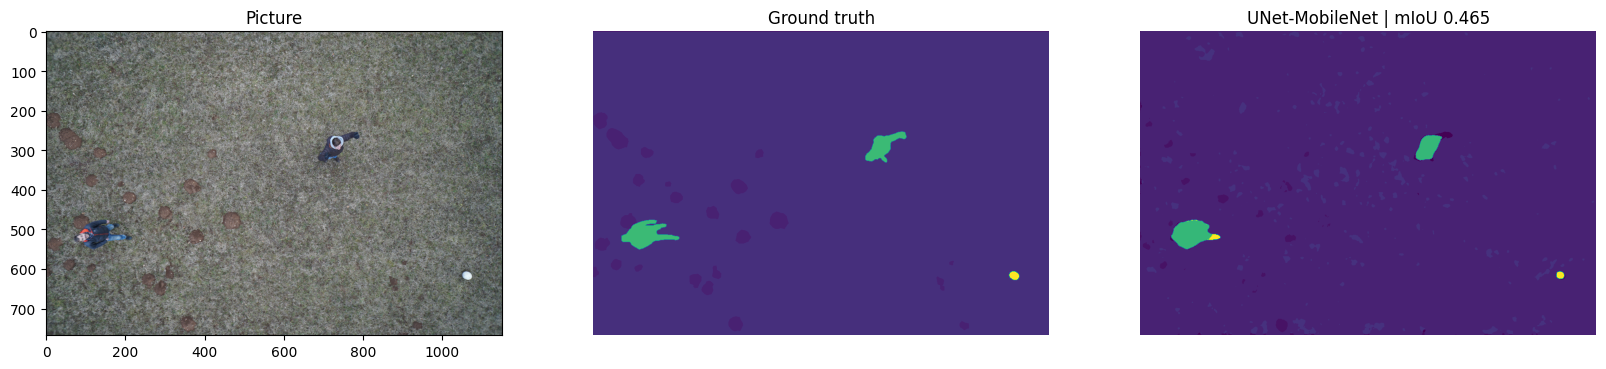

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

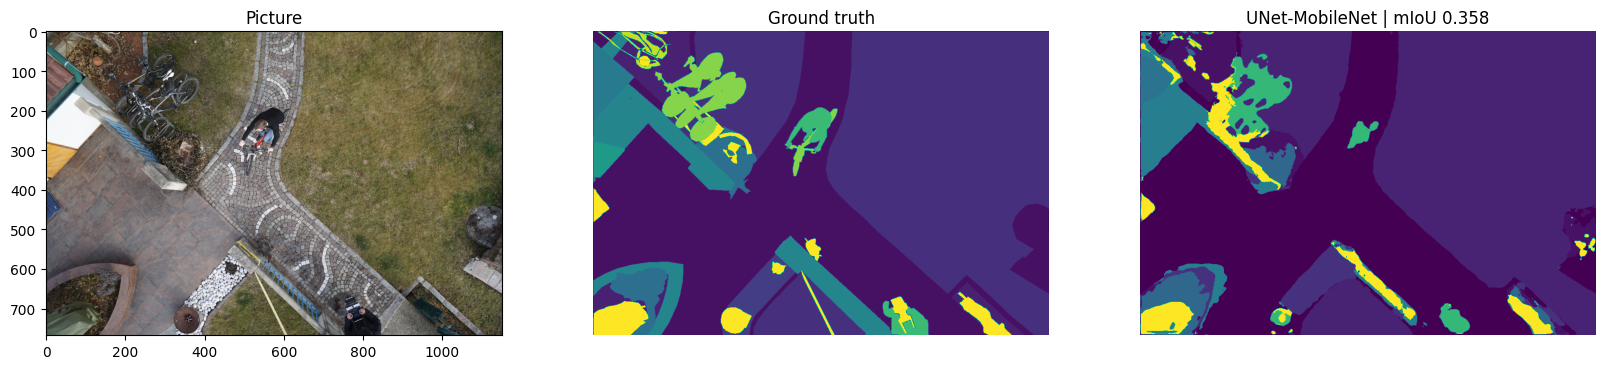

In [33]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()


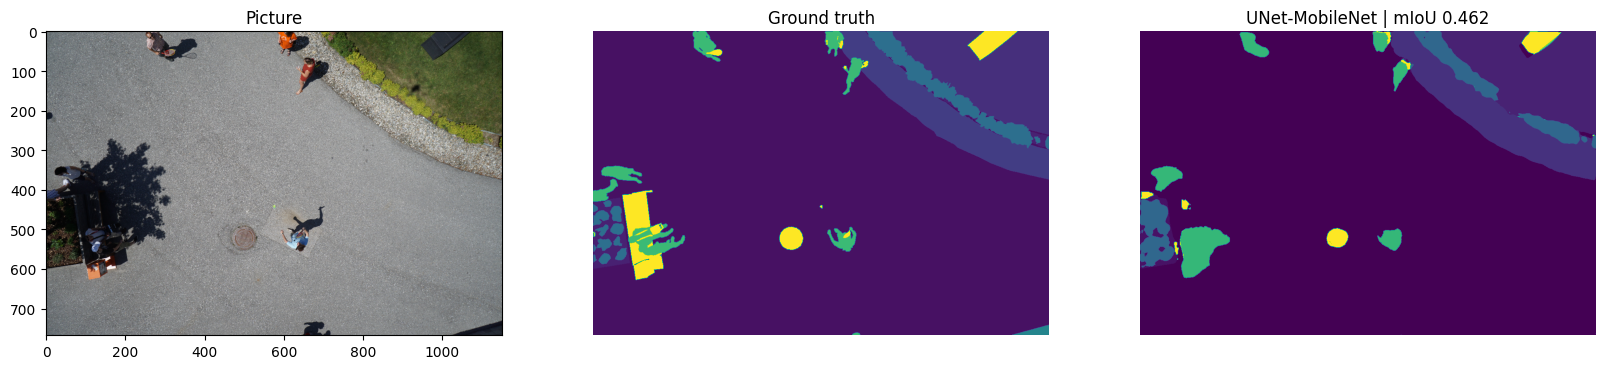

In [34]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [35]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.3332049301312816


In [36]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8398938496907553
